## Database Driven Machine Learning Model


Video game Logistic Regression - resample - EU from NA and JP

This notebook uses a heroku database driven ML model to predict EU Sales based on Platform, Genre, NA_Sales, and JP_Sales. The notebook sets the threshold for EU_Sales to some value independent of the median value of EU_Sales and investigates oversampling, undersampling, and combination sampling to balance the yes/no values for EU_Sales.

In [3]:
# Import dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd
import psycopg2
from config import config

%matplotlib inline
import matplotlib.pyplot as plt

### Read in data and remove unnecessary columns

In [6]:
#Define Function to Retrieve Data From Heroku
def get_Data():
    """ Connect to the PostgreSQL database server """
    conn = None
    try:
         # read connection parameters
        params = config()

        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(**params)
		
        # create a cursor
        cur = conn.cursor()
        
	# execute a statement
        sql = "SELECT gm.rank, gm.na_sales, gm.eu_sales, gm.jp_sales, " \
                "p.platform, " \
                "g.genre " \
                "FROM game gm " \
                "LEFT JOIN platform p " \
                "ON gm.platform_id=p.id " \
                "LEFT JOIN genre g " \
                "ON gm.genre_id=g.id"
            
        #print('PostgreSQL database query: ' sql)
        query = pd.read_sql_query(sql, conn)
        
        df = pd.DataFrame(query)
        return df
    # close the communication with the PostgreSQL
        cur.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
            print('Database connection closed.')

In [7]:
#Query Heroku For Data and create DataFrame
df = get_Data()
df

Connecting to the PostgreSQL database...
Database connection closed.


,rank,na_sales,eu_sales,jp_sales,platform,genre
0,1,41.49,29.02,3.77,Wii,Sports
1,2,29.08,3.58,6.81,NES,Platform
2,3,15.85,12.88,3.79,Wii,Racing
3,4,15.75,11.01,3.28,Wii,Sports
4,5,11.27,8.89,10.22,GB,Role-Playing
...,...,...,...,...,...,...
9795,9797,0.11,0.00,0.00,PSP,Racing
9796,9798,0.00,0.00,0.12,GEN,Adventure
9797,9799,0.01,0.00,0.11,PS3,Role-Playing
9798,9800,0.07,0.05,0.00,PS,Platform


In [10]:
# Reorder and Rename Columns for Machine Learning Model
vg_sales_df = df.reindex(columns= ['rank', 'platform', 'genre', 'na_sales', 'eu_sales', 'jp_sales'])
vg_sales_df.columns = ['Rank', 'Platform', 'Genre', 'NA_Sales', 'EU_Sales', 'JP_Sales']
vg_sales_df.set_index("Rank", inplace=True)
vg_sales_df

,Platform,Genre,NA_Sales,EU_Sales,JP_Sales
Rank,,,,,
1,Wii,Sports,41.49,29.02,3.77
2,NES,Platform,29.08,3.58,6.81
3,Wii,Racing,15.85,12.88,3.79
4,Wii,Sports,15.75,11.01,3.28
5,GB,Role-Playing,11.27,8.89,10.22
...,...,...,...,...,...
9797,PSP,Racing,0.11,0.00,0.00
9798,GEN,Adventure,0.00,0.00,0.12
9799,PS3,Role-Playing,0.01,0.00,0.11


In [11]:
# Get unique Platform values
vg_sales_df["Platform"].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       '3DS', 'PS4', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne', 'GC',
       'WiiU', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16'],
      dtype=object)

In [12]:
# Make sure there are no null values
vg_sales_df["Platform"].isnull().sum()

0

In [13]:
# Get unique Genre values
vg_sales_df["Genre"].unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy'], dtype=object)

In [14]:
# Make sure there are no null values
vg_sales_df["Genre"].isnull().sum()

0

In [15]:
# Make sure sales columns do not have null values
print(f"NA_Sales has {vg_sales_df['NA_Sales'].isnull().sum()} null values.")
print(f"EU_Sales has {vg_sales_df['EU_Sales'].isnull().sum()} null values.")
print(f"JP_Sales has {vg_sales_df['JP_Sales'].isnull().sum()} null values.")

NA_Sales has 0 null values.
EU_Sales has 0 null values.
JP_Sales has 0 null values.


### Histogram of Sales Data

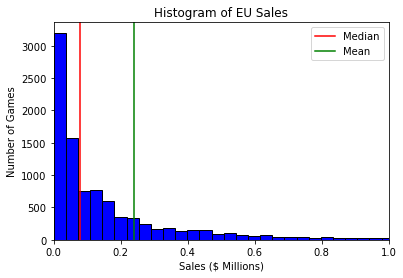

The median sales for EU is $0.08 Million


In [16]:
# Create Histogram to view NA Sales distribution
plt.hist(vg_sales_df['EU_Sales'], color = 'blue', edgecolor = 'black',
         bins = 800)
plt.title('Histogram of EU Sales')
plt.xlabel('Sales ($ Millions)')
plt.ylabel('Number of Games')
plt.xlim(left=0, right=1)
plt.axvline(vg_sales_df['EU_Sales'].median(),label="Median",color='red')
plt.axvline(vg_sales_df['EU_Sales'].mean(),label="Mean",color='green')
plt.legend()
plt.show()

print(f"The median sales for EU is ${round(vg_sales_df['EU_Sales'].median(),3)} Million")

### Categorize Other_Sales Column

In [17]:
# Copy vg_sales_df
categorize_eu_sales = vg_sales_df.filter(["EU_Sales"], axis=1)
categorize_eu_sales

,EU_Sales
Rank,
1,29.02
2,3.58
3,12.88
4,11.01
5,8.89
...,...
9797,0.00
9798,0.00
9799,0.00


In [18]:
# Set threshold sales number
# na_sales_threshold = round(sales_data_nrm['NA_Sales'].median(),3)
eu_sales_threshold = 0.2

# Reassign NA_sales value
for index,row in categorize_eu_sales.iterrows():
    
    # NA Sales
    if row.EU_Sales > eu_sales_threshold:
        categorize_eu_sales.loc[index] = 1
    else:
        categorize_eu_sales.loc[index] = 0

eu_sales_col_name = "EU_Sales_gt_" + str(eu_sales_threshold)
categorize_eu_sales.\
    rename(columns={"EU_Sales": eu_sales_col_name}, inplace=True)

categorize_eu_sales.head()

,EU_Sales_gt_0.2
Rank,
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0


### Separate Sales Data for NA and JP

In [19]:
sales_data = vg_sales_df.filter(["NA_Sales", "JP_Sales"], axis=1)
sales_data.head()

,NA_Sales,JP_Sales
Rank,,
1,41.49,3.77
2,29.08,6.81
3,15.85,3.79
4,15.75,3.28
5,11.27,10.22


In [20]:
# Create platform df
platform_df = vg_sales_df.filter(["Platform"], axis=1)
platform_df.head()

,Platform
Rank,
1,Wii
2,NES
3,Wii
4,Wii
5,GB


### Encode Platform data

In [21]:
# Encode platform df
platform_encoded_df = pd.get_dummies(platform_df)
platform_encoded_df.head()

,Platform_2600,Platform_3DS,Platform_DC,Platform_DS,Platform_GB,Platform_GBA,Platform_GC,Platform_GEN,Platform_N64,Platform_NES,...,Platform_SAT,Platform_SCD,Platform_SNES,Platform_TG16,Platform_WS,Platform_Wii,Platform_WiiU,Platform_X360,Platform_XB,Platform_XOne
Rank,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
# Get shape of platform_encoded_df
platform_encoded_df.shape

(9800, 28)

### Encode Genre data

In [23]:
# Create genre df
genre_df = vg_sales_df.filter(["Genre"], axis=1)
genre_df.head()

,Genre
Rank,
1,Sports
2,Platform
3,Racing
4,Sports
5,Role-Playing


In [24]:
# Encode genre df
genre_encoded_df = pd.get_dummies(genre_df)
genre_encoded_df.head()

,Genre_Action,Genre_Adventure,Genre_Fighting,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy
Rank,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,1,0
5,0,0,0,0,0,0,0,1,0,0,0,0


In [25]:
# Get shape of genre_encoded_df
genre_encoded_df.shape

(9800, 12)

### Combine dataframes for analysis

In [26]:
# Combine dataframes to create sales_df_encoded
sales_df_encoded = categorize_eu_sales.join(sales_data, how='outer').\
    join(platform_encoded_df, how='outer').join(genre_encoded_df, how='outer')
sales_df_encoded.head()

,EU_Sales_gt_0.2,NA_Sales,JP_Sales,Platform_2600,Platform_3DS,Platform_DC,Platform_DS,Platform_GB,Platform_GBA,Platform_GC,...,Genre_Fighting,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy
Rank,,,,,,,,,,,,,,,,,,,,,
1,1.0,41.49,3.77,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1.0,29.08,6.81,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,1.0,15.85,3.79,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1.0,15.75,3.28,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,1.0,11.27,10.22,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


In [28]:
# Create smaller df of 5000 rows selected randomly from larger dataset
sales_reduced = sales_df_encoded.sample(n=5000)
sales_reduced.head()

,EU_Sales_gt_0.2,NA_Sales,JP_Sales,Platform_2600,Platform_3DS,Platform_DC,Platform_DS,Platform_GB,Platform_GBA,Platform_GC,...,Genre_Fighting,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy
Rank,,,,,,,,,,,,,,,,,,,,,
9661,0.0,0.00,0.12,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1435,1.0,0.76,0.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1726,1.0,0.54,0.01,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
5588,0.0,0.23,0.02,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
6585,0.0,0.24,0.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [29]:
# Drop the index
sales_reduced_no_idx = sales_reduced.reset_index(drop=True)
sales_reduced_no_idx.head()

,EU_Sales_gt_0.2,NA_Sales,JP_Sales,Platform_2600,Platform_3DS,Platform_DC,Platform_DS,Platform_GB,Platform_GBA,Platform_GC,...,Genre_Fighting,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy
0,0.0,0.00,0.12,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,1.0,0.76,0.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,0.54,0.01,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0.0,0.23,0.02,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0.0,0.24,0.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


### Perform ML with Logistic Regression

In [30]:
# Count True/False NA_Sales numbers
sales_reduced_no_idx[eu_sales_col_name].value_counts()

0.0    3664
1.0    1336
Name: EU_Sales_gt_0.2, dtype: int64

In [31]:
# Set X and y data
y = sales_reduced_no_idx[eu_sales_col_name]
X = sales_reduced_no_idx.drop(columns=eu_sales_col_name)

In [32]:
# Split data into training and testing data
from collections import Counter
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1, 
                                                    stratify=y)
# X_train.shape
Counter(y_train)

Counter({0.0: 2748, 1.0: 1002})

#### Oversample Data

Random Oversampling

In [33]:
# implement random oversampling
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

Counter(y_resampled)

Counter({0.0: 2748, 1.0: 2748})

In [34]:
# Create a logistic regression model
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver='lbfgs',
                                max_iter=200,
                                random_state=1)

In [35]:
# Train the model
# classifier.fit(X_train, y_train)
classifier.fit(X_resampled, y_resampled)

LogisticRegression(max_iter=200, random_state=1)

In [36]:
y_pred = classifier.predict(X_test)
results = pd.DataFrame({"Prediction": y_pred, "Actual": y_test}).reset_index(drop=True)
results.head(10)

,Prediction,Actual
0,0.0,0.0
1,0.0,0.0
2,1.0,0.0
3,1.0,1.0
4,1.0,1.0
5,0.0,1.0
6,0.0,0.0
7,1.0,1.0
8,1.0,1.0
9,0.0,0.0


In [37]:
# Assess accuracy
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.824


In [38]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, y_pred)

0.8076249248228433

In [39]:
# # Print confusion matrix
# from sklearn.metrics import confusion_matrix, classification_report
# matrix = confusion_matrix(y_test, y_pred)
# print(matrix)

# Display the confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

# Calculating the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual < threshold", "Actual > threshold"], 
        columns=["Predicted < threshold", "Predicted > threshold"])

cm_df

,Predicted < threshold,Predicted > threshold
Actual < threshold,772,144
Actual > threshold,76,258


In [40]:
# Print classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.91      0.84      0.88       916
         1.0       0.64      0.77      0.70       334

    accuracy                           0.82      1250
   macro avg       0.78      0.81      0.79      1250
weighted avg       0.84      0.82      0.83      1250



In [41]:
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE(random_state=1,
sampling_strategy='auto').fit_resample(
   X_train, y_train)

Counter(y_resampled)

Counter({0.0: 2748, 1.0: 2748})

In [42]:
# Create a logistic regression model
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver='lbfgs',
                                max_iter=200,
                                random_state=1)

In [43]:
# Train the model
classifier.fit(X_resampled, y_resampled)

LogisticRegression(max_iter=200, random_state=1)

In [44]:
y_pred = classifier.predict(X_test)
results = pd.DataFrame({"Prediction": y_pred, "Actual": y_test}).reset_index(drop=True)
results.head(10)

,Prediction,Actual
0,0.0,0.0
1,0.0,0.0
2,1.0,0.0
3,1.0,1.0
4,1.0,1.0
5,0.0,1.0
6,0.0,0.0
7,1.0,1.0
8,1.0,1.0
9,0.0,0.0


In [45]:
# Assess accuracy
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.824


In [46]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, y_pred)

0.8066737703632038

In [47]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

# Calculating the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual < threshold", "Actual > threshold"], 
        columns=["Predicted < threshold", "Predicted > threshold"])

cm_df

,Predicted < threshold,Predicted > threshold
Actual < threshold,773,143
Actual > threshold,77,257


In [48]:
# Print classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.91      0.84      0.88       916
         1.0       0.64      0.77      0.70       334

    accuracy                           0.82      1250
   macro avg       0.78      0.81      0.79      1250
weighted avg       0.84      0.82      0.83      1250



#### Undersample Data

Random Undersampling

In [49]:
# Undersample the data using `RandomUnderSampler`
from imblearn.under_sampling import RandomUnderSampler
ros = RandomUnderSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({0.0: 1002, 1.0: 1002})

In [50]:
# Create a logistic regression model
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver='lbfgs',
                                max_iter=200,
                                random_state=1)

In [51]:
# Train the model
classifier.fit(X_resampled, y_resampled)

LogisticRegression(max_iter=200, random_state=1)

In [52]:
y_pred = classifier.predict(X_test)
results = pd.DataFrame({"Prediction": y_pred, "Actual": y_test}).reset_index(drop=True)
results.head(10)

,Prediction,Actual
0,0.0,0.0
1,0.0,0.0
2,1.0,0.0
3,1.0,1.0
4,1.0,1.0
5,0.0,1.0
6,0.0,0.0
7,1.0,1.0
8,1.0,1.0
9,0.0,0.0


In [53]:
# Assess accuracy
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.82


In [54]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, y_pred)

0.81060259393876

In [55]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

# Calculating the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual < threshold", "Actual > threshold"], 
        columns=["Predicted < threshold", "Predicted > threshold"])

cm_df

,Predicted < threshold,Predicted > threshold
Actual < threshold,761,155
Actual > threshold,70,264


In [56]:
# Print classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.92      0.83      0.87       916
         1.0       0.63      0.79      0.70       334

    accuracy                           0.82      1250
   macro avg       0.77      0.81      0.79      1250
weighted avg       0.84      0.82      0.83      1250



In [57]:
# Fit the data using `ClusterCentroids` and check the count of each class
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state=1)
X_resampled, y_resampled = cc.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({0.0: 1002, 1.0: 1002})

In [58]:
# Create a logistic regression model
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver='lbfgs',
                                max_iter=200,
                                random_state=1)

In [59]:
# Train the model
classifier.fit(X_resampled, y_resampled)

LogisticRegression(max_iter=200, random_state=1)

In [60]:
y_pred = classifier.predict(X_test)
results = pd.DataFrame({"Prediction": y_pred, "Actual": y_test}).reset_index(drop=True)
results.head(10)

,Prediction,Actual
0,0.0,0.0
1,0.0,0.0
2,1.0,0.0
3,1.0,1.0
4,1.0,1.0
5,0.0,1.0
6,0.0,0.0
7,1.0,1.0
8,1.0,1.0
9,0.0,0.0


In [62]:
 #Assess accuracy
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.8048


In [63]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, y_pred)

0.8154498862536934

In [64]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

# Calculating the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual < threshold", "Actual > threshold"], 
        columns=["Predicted < threshold", "Predicted > threshold"])

cm_df

,Predicted < threshold,Predicted > threshold
Actual < threshold,726,190
Actual > threshold,54,280


In [65]:
# Print classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.93      0.79      0.86       916
         1.0       0.60      0.84      0.70       334

    accuracy                           0.80      1250
   macro avg       0.76      0.82      0.78      1250
weighted avg       0.84      0.80      0.81      1250



#### Combination Sampling

In [66]:
# Use the SMOTEENN technique to perform combination sampling on the data
# Count the resampled classes
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(random_state=1)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({0.0: 1880, 1.0: 1832})

In [67]:
# Create a logistic regression model
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver='lbfgs',
                                max_iter=200,
                                random_state=1)

In [68]:
# Train the model
classifier.fit(X_resampled, y_resampled)

LogisticRegression(max_iter=200, random_state=1)

In [69]:
y_pred = classifier.predict(X_test)
results = pd.DataFrame({"Prediction": y_pred, "Actual": y_test}).reset_index(drop=True)
results.head(10)

,Prediction,Actual
0,0.0,0.0
1,0.0,0.0
2,1.0,0.0
3,1.0,1.0
4,1.0,1.0
5,0.0,1.0
6,0.0,0.0
7,1.0,1.0
8,1.0,1.0
9,0.0,0.0


In [70]:
# Assess accuracy
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.8216


In [71]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, y_pred)

0.8154989148340872

In [72]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

# Calculating the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual < threshold", "Actual > threshold"], 
        columns=["Predicted < threshold", "Predicted > threshold"])

cm_df

,Predicted < threshold,Predicted > threshold
Actual < threshold,759,157
Actual > threshold,66,268


In [73]:
# Print classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.92      0.83      0.87       916
         1.0       0.63      0.80      0.71       334

    accuracy                           0.82      1250
   macro avg       0.78      0.82      0.79      1250
weighted avg       0.84      0.82      0.83      1250

